# 10b: Particle tracking with MODPATH
In this exercise, we will use MODPATH to simulate advective transport with the Freyberg flow model. 

MODPATH is a particle tracking software that simulates the advective transport of particles using the output from a MODFLOW groundwater flow model. The MODPATH user guide, documentation, and executable can be found [here](https://www.usgs.gov/software/modpath-particle-tracking-model-modflow). The MODPATH executable is downloaded with the stack of modflow related programs when `get_modflow()` was run in setup for this course. Students should already have this program on their machines.

For this exercise, we will use a quadtree version of the Freyberg model.

In [1]:
from IPython.display import clear_output, display
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from flopy.utils.gridintersect import GridIntersect
import flopy
import pandas as pd

The location of the contamination patch and the nodes that the define bounding cells of the patch are calculated below.

In [2]:
# patch upper left and lower right
xmin, xmax = 250. * 1, 250. * 3
ymin, ymax = (40 - 14) * 250., (40 - 11) * 250. 

csx, csy = [xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin]
polygon = [list(zip(csx, csy))]
(xmin, ymax), (xmax, ymin)

((250.0, 7250.0), (750.0, 6500.0))

--------------------------

### Define the workspace and model names.

In [3]:
load_ws = Path('data/quadtree')
ws = Path("temp/ex10a")
name = "project"
name_mp = f"{name}_mp"
exe_name = 'mf6'

## Load the MODFLOW 6 Model

Load a simulation object using `flopy.mf6.MFSimulation().load()`.

In [4]:
%%capture
sim = flopy.mf6.MFSimulation.load(sim_name=name, exe_name=exe_name,
                                    sim_ws=load_ws)

### Load the groundwater flow model

In [5]:
gwf = sim.get_model(name)
gwf.modelgrid

xll:0.0; yll:0.0; rotation:0.0; units:meters; lenuni:2

### Change the workspace

In [6]:
sim.set_sim_path(ws)

### Write the model files

In [7]:
%%capture
sim.write_simulation()

Run the simulation.

In [8]:
sim.run_simulation()

FileNotFoundError: The program mf6 does not exist or is not executable.

## Create and Run the MODPATH model


### Lets plot the model grid and the location of the contamination patch.

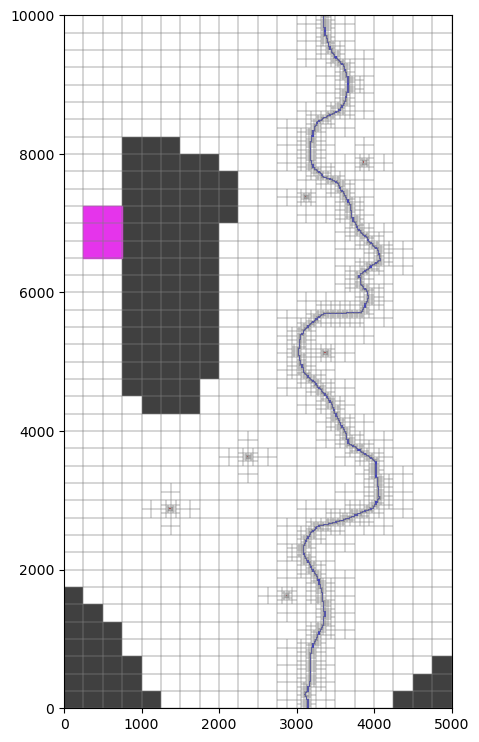

In [9]:
fig, ax = plt.subplots(figsize=(5, 9))
mm = flopy.plot.PlotMapView(gwf, layer=0, ax=ax)

mm.plot_bc('SFR', color="b", plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_inactive(alpha=0.75)

mm.plot_grid(lw=0.25, color='grey')

ax.fill(csx, csy, color='#e534eb');

Find the node numbers of the contamination patch using the groundwater model grid object and the `GridIntersect` utility. The `GridIntersect` utility has an `intersect` method that can be used to identified cellids from points, lines, and polygons.

In [10]:
gx = GridIntersect(gwf.modelgrid)
results = gx.intersect(polygon, 'Polygon')
nodes = results.cellids
nodes

array([1352, 1353, 1459, 1460, 1581, 1582], dtype=object)

### Create the MODPATH particle data

In [11]:
# create
sd = flopy.modpath.CellDataType()
p = flopy.modpath.NodeParticleData(subdivisiondata=[sd],
                                   nodes=list(nodes))
# create forward particle group
fpth = name_mp + '.sloc'
pg = flopy.modpath.ParticleGroupNodeTemplate(particlegroupname='contaminant',
                                             particledata=p,
                                             filename=fpth)

AttributeError: 'CellDataType' object has no attribute 'data'

### Create the MODPATH 7 files

In [15]:
# create modpath files
mp = flopy.modpath.Modpath7(modelname=name_mp, flowmodel=gwf,
                            exe_name='mp7', model_ws=ws)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='pathline', 
                                  trackingdirection='forward',
                                  weaksinkoption='pass_through',
                                  weaksourceoption='pass_through',
                                  referencetime=0.,
                                  stoptimeoption='extend',
                                  particlegroups=pg)
help(flopy.modpath.Modpath7Sim)

Help on class Modpath7Sim in module flopy.modpath.mp7sim:

class Modpath7Sim(flopy.pakbase.Package)
 |  Modpath7Sim(model, mpnamefilename=None, listingfilename=None, endpointfilename=None, pathlinefilename=None, timeseriesfilename=None, tracefilename=None, simulationtype='pathline', trackingdirection='forward', weaksinkoption='stop_at', weaksourceoption='stop_at', budgetoutputoption='no', traceparticledata=None, budgetcellnumbers=None, referencetime=None, stoptimeoption='extend', stoptime=None, timepointdata=None, zonedataoption='off', stopzone=None, zones=0, retardationfactoroption='off', retardation=1.0, particlegroups=None, extension='mpsim')
 |
 |  MODPATH Simulation File Package Class.
 |
 |  Parameters
 |  ----------
 |  model : model object
 |      The model object (of type :class:`flopy.modpath.Modpath7`) to
 |      which this package will be added.
 |  mpnamefilename : str
 |      Filename of the MODPATH 7 name file. If mpnamefilename is not
 |      defined it will be generate

/Users/aleaf/miniforge3/envs/pyclass/lib/python3.12/site-packages/flopy/mbase.py:104: UserWarning: The program mp7 does not exist or is not executable.
  warn(


### Write MODPATH 7 files and run the model

In [16]:
# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

ValueError: An executable name or path must be provided

## Post-Process the MODFLOW and MODPATH Results


### Load MODFLOW and MODPATH results from the heads and pathline files

Load the MODFLOW heads

In [17]:
hobj = gwf.output.head()

In [18]:
hds = hobj.get_data()

Load the pathline file

In [21]:
ppth =ws / f"{name_mp}.mppth"
p = flopy.utils.PathlineFile(ppth)
p0 = p.get_alldata()

In [22]:
p0[0:2]

[array([(0, 0, 0, 0,     0.   ,  291.66666, 7041.6665, 25.157747 , 0,  1352, 0.16666667, 0.16666667, 1.6666667e-01, 1, 1),
        (0, 0, 0, 0,  1066.425,  292.2685 , 7053.4917, 24.259151 , 0,  1352, 0.16907398, 0.21396767, 0.0000000e+00, 1, 1),
        (0, 0, 0, 0,  9177.14 ,  296.90045, 7187.993 , 18.867577 , 1,  6460, 0.18760175, 0.7519722 , 0.0000000e+00, 1, 1),
        (0, 0, 0, 0, 11623.706,  298.3129 , 7250.    , 17.850622 , 2, 11568, 0.19325161, 1.        , 8.1138092e-01, 1, 1),
        (0, 0, 0, 0, 17445.506,  327.38663, 7500.    , 17.049046 , 2, 11413, 0.3095466 , 1.        , 4.6866903e-01, 1, 1),
        (0, 0, 0, 0, 21365.98 ,  351.95578, 7750.    , 14.893128 , 2, 11258, 0.40782306, 1.        , 3.3380401e-01, 1, 1),
        (0, 0, 0, 0, 24204.107,  384.25403, 8000.    , 14.742931 , 2, 11103, 0.53701615, 1.        , 2.5803149e-01, 1, 1),
        (0, 0, 0, 0, 26379.746,  437.96545, 8250.    , 15.481973 , 2, 11002, 0.7518618 , 1.        , 2.0690233e-01, 1, 1),
        (0, 0, 0

### Plot the heads and pathlines

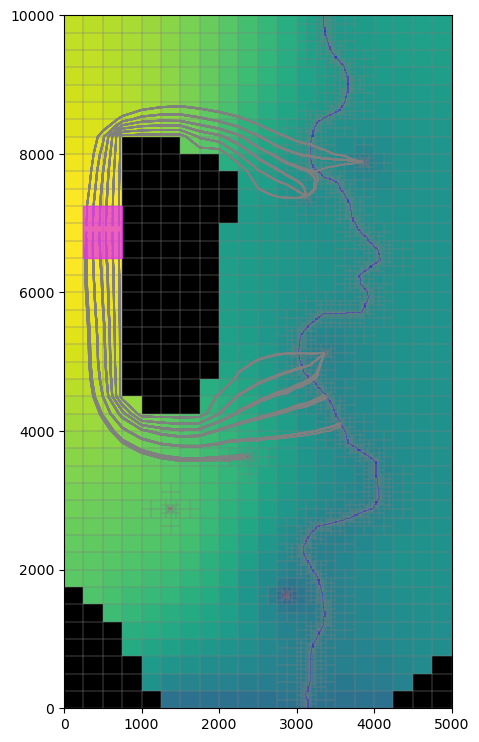

In [23]:
fig, ax = plt.subplots(figsize=(5, 9))
mm = flopy.plot.PlotMapView(model=gwf, layer=0, ax=ax)
mm.plot_array(hds, masked_values=[1e30])

mm.plot_bc('SFR', color='b', plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_ibound()
mm.plot_pathline(p0, layer='all', color='blue', lw=1)
mm.plot_grid(lw=0.2, color="0.5")

ax = plt.gca()
ax.fill(csx, csy, color='#e534eb', zorder=100, alpha=.75);

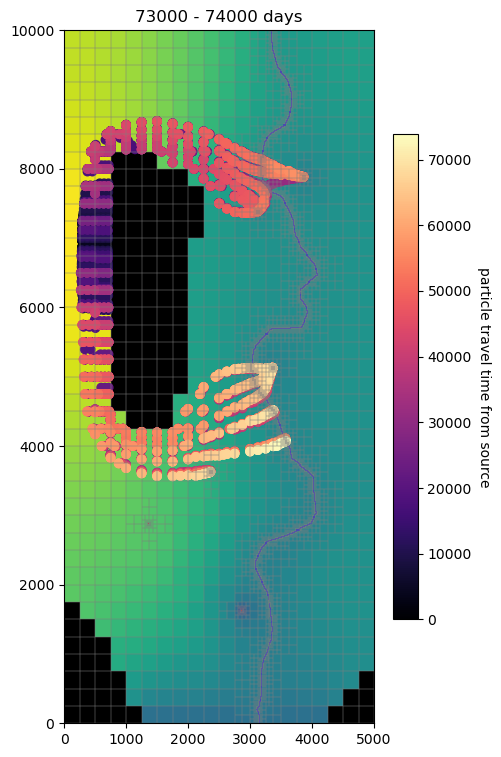

In [19]:
fig, ax = plt.subplots(figsize=(5, 9))

mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
mm.plot_array(hds, masked_values=[1e30])
mm.plot_bc('SFR', color='b', plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_ibound()
mm.plot_grid(lw=0.2, color="0.5")

p = flopy.utils.PathlineFile(ppth)
p0 = p.get_alldata()
df = pd.DataFrame.from_records(p0[0])
for ix, recarray in enumerate(p0):
    dft = pd.DataFrame.from_records(recarray)
    df = pd.concat((df, dft), ignore_index=True)
vmin, vmax = df.time.min(), df.time.max()

times = list(range(0, 74001, 1000))
for ix in range(1, len(times)):
    tmp = df[(df.time >= times[ix - 1]) & (df.time < times[ix])]
    s = ax.scatter(tmp.x.values, tmp.y.values, c=tmp.time.values, vmin=vmin, vmax=vmax, cmap="magma")
    ax.set_title(f"{times[ix - 1]} - {times[ix]} days")
    if ix == 1:
        cbar = fig.colorbar(s, shrink=0.7)
        cbar.set_label('particle travel time from source', rotation=270, labelpad=14)
    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)    

### Export the pathlines to a shapefile

In [ ]:
spth = Path(ws / 'pathline.shp')
p.write_shapefile(p0, mg=gwf.modelgrid, one_per_particle=False, shpname=spth)

[('particleid', '<i4'), ('particlegroup', '<i4'), ('sequencenumber', '<i4'), ('particleidloc', '<i4'), ('time', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('k', '<i4'), ('node', '<i4'), ('xloc', '<f4'), ('yloc', '<f4'), ('zloc', '<f4'), ('stressperiod', '<i4'), ('timestep', '<i4')]


C:\Users\jlarsen\Documents\anaconda3\envs\pyclass3\Lib\site-packages\flopy\export\shapefile_utils.py:496: UserWarning: Truncating shapefile fieldname particlegroup to partiroup_
  warn(f"Truncating shapefile fieldname {s} to {name}")
C:\Users\jlarsen\Documents\anaconda3\envs\pyclass3\Lib\site-packages\flopy\export\shapefile_utils.py:496: UserWarning: Truncating shapefile fieldname sequencenumber to sequember_
  warn(f"Truncating shapefile fieldname {s} to {name}")
C:\Users\jlarsen\Documents\anaconda3\envs\pyclass3\Lib\site-packages\flopy\export\shapefile_utils.py:496: UserWarning: Truncating shapefile fieldname particleidloc to partidloc_
  warn(f"Truncating shapefile fieldname {s} to {name}")
C:\Users\jlarsen\Documents\anaconda3\envs\pyclass3\Lib\site-packages\flopy\export\shapefile_utils.py:496: UserWarning: Truncating shapefile fieldname stressperiod to stresriod_
  warn(f"Truncating shapefile fieldname {s} to {name}")


No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


### Load the shapefile into geopandas

In [21]:
rshp = gpd.read_file(spth)

### Show the dataframe

In [22]:
rshp

,particleid,partiroup_,sequember_,partidloc_,time,x,y,z,k,node,xloc,yloc,zloc,stresriod_,timestep,geometry
0,1,1,1,1,1066.444824,292.266235,7053.407715,24.259151,1,1353,0.169065,0.213630,0.000000,1,1,"LINESTRING (291.667 7041.667, 292.266 7053.408)"
1,1,1,1,1,9176.973633,296.880524,7186.960938,18.867577,2,6461,0.187522,0.747843,0.000000,1,1,"LINESTRING (292.266 7053.408, 296.881 7186.961)"
2,1,1,1,1,11675.894531,298.317780,7250.000000,17.831028,3,11569,0.193271,1.000000,0.807747,1,1,"LINESTRING (296.881 7186.961, 298.318 7250)"
3,1,1,1,1,17508.531250,327.402008,7500.000000,17.036358,3,11414,0.309608,1.000000,0.466072,1,1,"LINESTRING (298.318 7250, 327.402 7500)"
4,1,1,1,1,21433.228516,351.983856,7750.000000,14.882585,3,11259,0.407935,1.000000,0.331823,1,1,"LINESTRING (327.402 7500, 351.984 7750)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7326,162,1,162,162,49935.636719,3312.500000,5125.286133,1.553995,3,12772,1.000000,0.004577,0.009084,1,1,"LINESTRING (3305.245 5125, 3312.5 5125.286)"
7327,162,1,162,162,49954.375000,3328.125000,5128.049805,1.580439,3,12775,0.500000,0.097600,0.008830,1,1,"LINESTRING (3312.5 5125.286, 3328.125 5128.05)"
7328,162,1,162,162,49966.113281,3343.750000,5128.823730,1.579678,3,12775,1.000000,0.122366,0.008674,1,1,"LINESTRING (3328.125 5128.05, 3343.75 5128.824)"
7329,162,1,162,162,49971.105469,3359.375000,5131.083496,1.578258,3,12778,1.000000,0.389351,0.005555,1,1,"LINESTRING (3343.75 5128.824, 3359.375 5131.083)"


### Plot the geopandas dataframe on the modelgrid

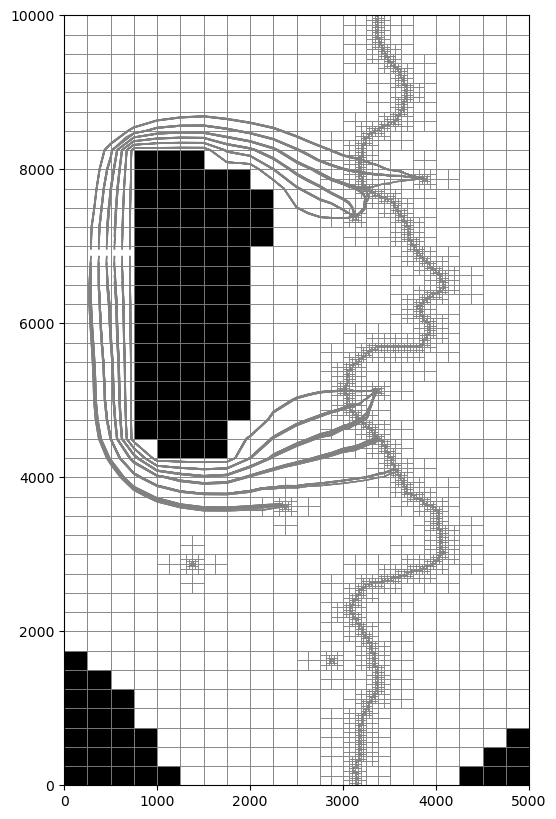

In [23]:
fig, ax = plt.subplots(figsize=(6, 10))
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pmv.plot_grid(lw=0.5)
pmv.plot_shapes(rshp.geometry.to_list(), edgecolor="grey") #, edgecolor="b")
pmv.plot_ibound();

## Export the data to VTK (Visualization ToolKit) format for a 3d representation

FloPy's `Vtk` module allows us to create Visualization ToolKit (VTK) files that can be opened and explored with pyVISTAs or external software such as ParaView.

In [24]:
from flopy.export.vtk import Vtk

vtk = Vtk(model=gwf, binary=False, vertical_exageration=50, smooth=False)
vtk.add_model(gwf)
vtk.add_pathline_points(p0)

Write VTK file for use in ParaView or other VTK software

In [ ]:
pth = Path("temp")
pth.mkdir(exist_ok=True)

vtk.write(pth / "freyberg")

## Alternatively we can visualize the VTK representation using `pyvista`. To activate these cells, set `plotvtk=True`

In [26]:
plotvtk = True
if plotvtk:
    import pyvista as pv

Convert the VTK to pyvista meshes and rotate the meshes to match the orientation of our matplotlib plots

In [27]:
if plotvtk:
    grid, pathlines = vtk.to_pyvista()

In [28]:
if plotvtk:
    axes = pv.Axes(show_actor=True, actor_scale=2.0, line_width=5)

    grid.rotate_z(160, point=axes.origin, inplace=True)
    pathlines.rotate_z(160, point=axes.origin, inplace=True)

Select particle release locations and build a dictionary of particle tracks (pathlines). This will be used below for particle labelling, as well as for animation.

*Note*: while below we construct pathlines manually from data read from the exported VTK files, pathlines may also be read directly from the MODPATH 7 pathline output file (provided the simulation was run in pathline or combined mode, as this one was).

In [29]:
if plotvtk:
    tracks = {}
    particle_ids = set()
    release_locs = list()

    for i, t in enumerate(pathlines["time"]):
        pid = str(round(float(pathlines["particleid"][i])))
        loc = pathlines.points[i]

        if pid not in tracks:
            tracks[pid] = []
            particle_ids.add(pid)
            release_locs.append(loc)

        # store the particle location in the corresponding track
        tracks[pid].append((loc, t))

    release_locs = np.array(release_locs)
    tracks = {k: np.array(v, dtype=object) for k, v in tracks.items()}
    max_track_len = max([len(v) for v in tracks.values()])

View the grid and pathlines with PyVista, with particle tracks/locations colored by time. Also add particle ID labels to a few particles’ release locations.

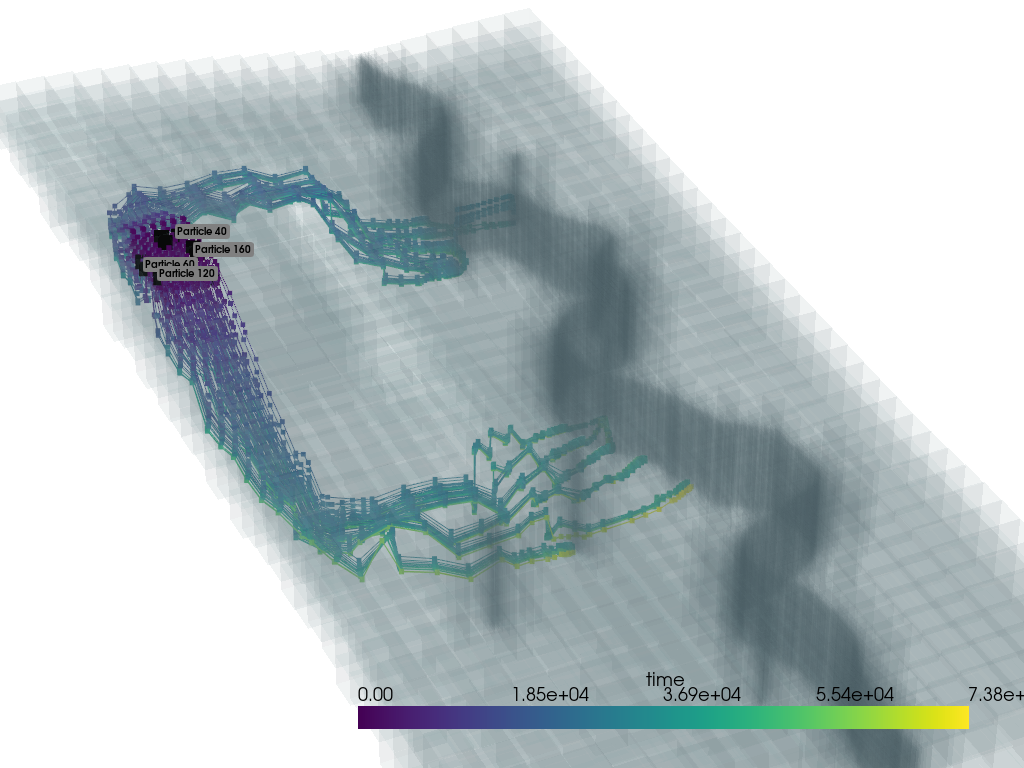

In [30]:
if plotvtk:
    pv.set_plot_theme("document")
    pv.set_jupyter_backend("static")

    # create the plot and add the grid and pathline meshes
    p = pv.Plotter()
    p.add_mesh(grid, opacity=0.05)
    p.add_mesh(pathlines, scalars="time")

    # add a particle ID label to each 20th particle's starting point
    label_coords = []
    start_labels = []
    for pid, track in tracks.items():
        if int(pid) % 20 == 0:
            label_coords.append(track[0][0])
            start_labels.append(f"Particle {pid}")

    p.add_point_labels(
        label_coords,
        start_labels,
        font_size=10,
        point_size=15,
        point_color="black",
    )

    # zoom in and show the plot
    p.camera.zoom(2.4)
    p.show()

Create an animated GIF of the particles traveling along their pathlines, with particles colored by time.

In [31]:
if plotvtk:
    # create plotter
    p = pv.Plotter(notebook=False, off_screen=True)

    # open GIF file
    gif_path = pth / f"freyberg_tracks.gif"
    p.open_gif(str(gif_path))

    # create mesh from release locations
    spls = pv.PolyData(release_locs)
    spls.point_data["time"] = np.zeros(len(spls.points))

    # add the underlying grid mesh and particle data, then zoom in
    p.add_mesh(grid, opacity=0.05)
    p.add_mesh(spls, clim=[0, 1.23e09])
    p.camera.zoom(2.4)
    
    # cycle through time steps and update particle location
    for i in range(1, max_track_len):
        pts = []
        times = []
        segments = []

        for pid in particle_ids:
            track = tracks[pid]
            npts = len(track)
            # use last locn if particle has already terminated
            loc, t = track[i] if i < npts else track[npts - 1]
            pts.append(loc)
            times.append(t)
            if i < npts:
                segments.append(track[i - 1][0])
                segments.append(loc)

        spls.points = np.vstack(pts)
        spls.point_data["time"] = np.array(times)
        p.add_lines(np.array(segments), width=1, color="black")
        p.write_frame()  # write frame to file

    # close the plotter and the GIF file
    p.close()

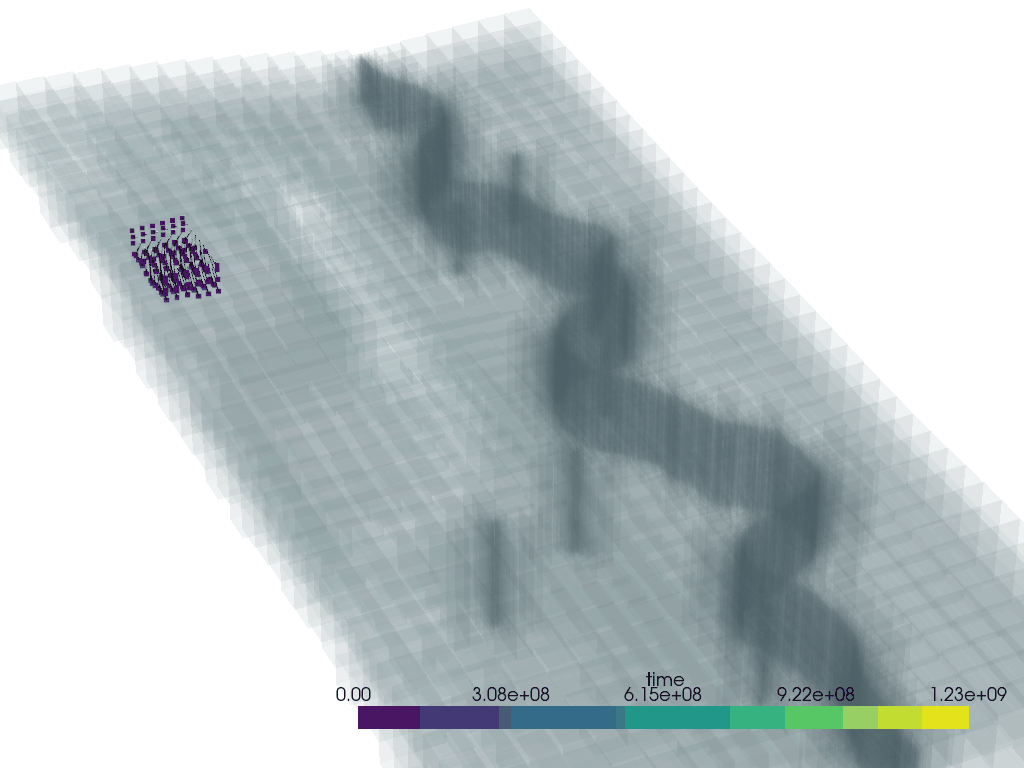

In [32]:
if plotvtk:
    from IPython.core.display import Image

    display(Image(data=open(gif_path, "rb").read(), format="gif"))